In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [6]:
len(dataset),131*32

(131, 4192)

In [7]:
print(image_batch[0].shape)### tensor object

NameError: name 'image_batch' is not defined

In [ ]:
print(image_batch[0].numpy()) #(256,256,3) and by default is in float type so to plot convert to uint8

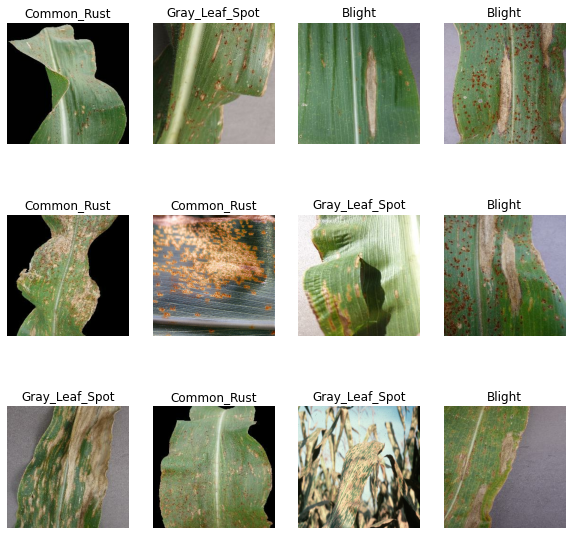

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1): #every element we get is numpy so we convert to tensor
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        #print(label_batch.numpy())

### Data splitting

### 80 % training ,20% -> 10% validation(validate for at end of each epoch) and 10% test

In [15]:
train_size = 0.8
round(len(dataset)*0.8)

105

In [16]:
train_ds = dataset.take(105)
len(train_ds)

105

In [17]:
ds_20_perc = dataset.skip(105)
len(ds_20_perc)

26

In [18]:
val_size = 0.1*len(dataset)
round(val_size)

13

In [19]:
val_ds = ds_20_perc.take(13)
len(val_ds)

13

In [20]:
test_ds = ds_20_perc.skip(13)
len(test_ds)

13

In [21]:
len(dataset) #batch wise

131

In [22]:
len(train_ds)+len(val_ds)+len(test_ds)

131

In [8]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [10]:
len(train_ds),len(val_ds), len(test_ds),len(dataset)

(104, 13, 14, 131)

### Using training dataset we first do caching,this will read the image from the disk and  for next iteration when u need the same image; it will keep the same image in memory which ultimately improves  the performance of the pipeline like you dont wait for the next time slot to read image its just pushed into cache


### Then u prefetch like if u have a gpu and cpu and if gpu is busy training the cpu gets the next batch of data to train ready parallely within that time slot. Also we allow  the tensorflow to decide how many batches to load while gpu is training

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resi_resc = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmented  = tf.keras.Sequential([  ##taking an original image and rotating and flipping the image at certain angles and 
                                         #creating samples. this helps in avoiding overfitting
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    
    #stacling the preproccesing layers before cnn
    resi_resc, #resizing and rescaleing
    data_augmented,
    
    #CNN more no of filters are needed if you wanna detect more edges
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #end of CNN architecture o/p 
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #normalizes probablity of classes
    
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [30]:
model.compile(

    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [28]:
history = model.fit(
    
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
104/104 [==============================] - 320s 199ms/step - loss: 1.0144 - accuracy: 0.4768 - val_loss: 0.8793 - val_accuracy: 0.5601
Epoch 2/50
104/104 [==============================] - 7s 72ms/step - loss: 0.8416 - accuracy: 0.5954 - val_loss: 0.8151 - val_accuracy: 0.6635
Epoch 3/50
104/104 [==============================] - 7s 71ms/step - loss: 0.4703 - accuracy: 0.8141 - val_loss: 0.3938 - val_accuracy: 0.8245
Epoch 4/50
104/104 [==============================] - 7s 72ms/step - loss: 0.3852 - accuracy: 0.8336 - val_loss: 0.3436 - val_accuracy: 0.8438
Epoch 5/50
104/104 [==============================] - 7s 72ms/step - loss: 0.3264 - accuracy: 0.8592 - val_loss: 0.3373 - val_accuracy: 0.8510
Epoch 6/50
104/104 [==============================] - 7s 71ms/step - loss: 0.3147 - accuracy: 0.8755 - val_loss: 0.2867 - val_accuracy: 0.8726
Epoch 7/50
104/104 [==============================] - 7s 71ms/step - loss: 0.2799 - accuracy: 0.8872 - val_loss: 0.2667 - val_accuracy: 0.8

In [29]:
scores = model.evaluate(test_ds)
scores

14/14 [==============================] - 12s 31ms/step - loss: 0.1981 - accuracy: 0.9219


[0.19808785617351532, 0.921875]

In [30]:
history.params

{'epochs': 50, 'steps': 104, 'verbose': 1}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
len(history.history['accuracy'])

50

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
range(EPOCHS)

range(0, 50)

In [ ]:
loss

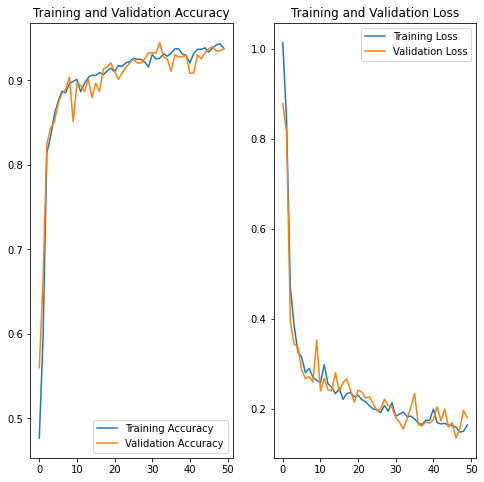

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Common_Rust
predicted label: Common_Rust


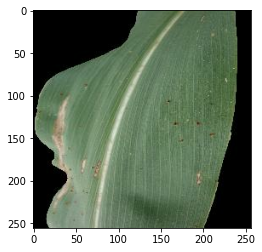

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8') #3d array
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

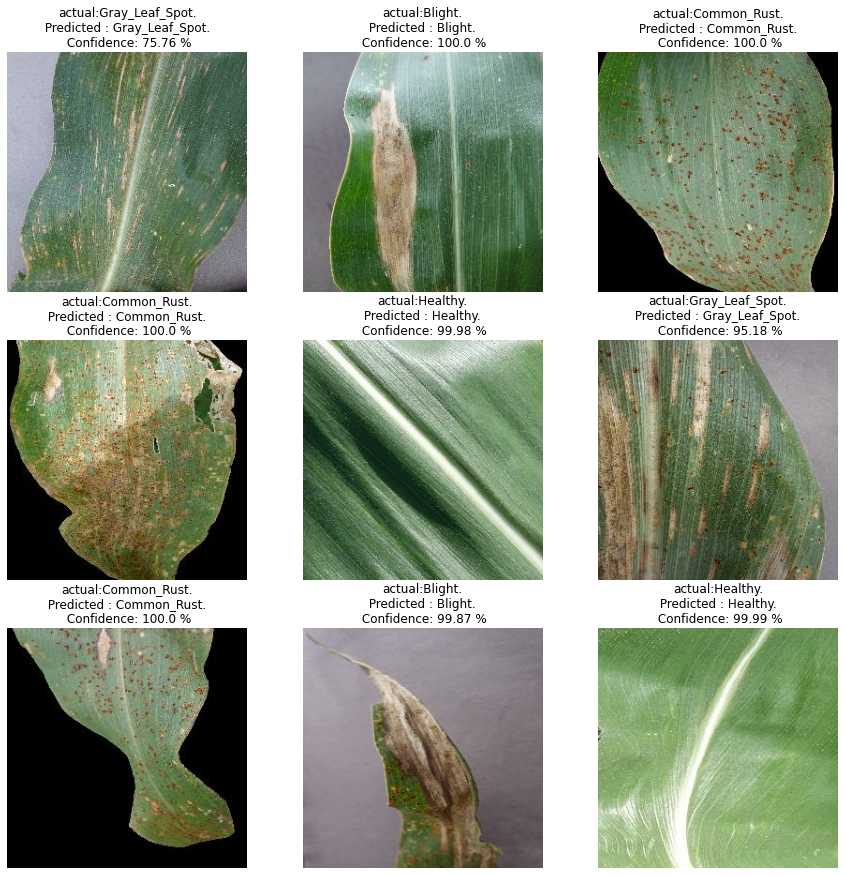

In [47]:
plt.figure(figsize = (15,15))

for images,labels in test_ds.take(1):
    
      for i in range(9):
            
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype('uint8'))

            predicted_class, confidence = predict(model,images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"actual:{actual_class}.\n Predicted : {predicted_class}. \n Confidence: {confidence} %")
            plt.axis("off")

In [32]:
import os
model_version = 2
#url = "/content/drive/MyDrive/corn_disease_project/Corn-disease-classification/models/"
#model_version  = [int(i) for  i in os.listdir(url) + [0]]+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [3]:
print(tf. __version__)

2.9.1


In [16]:
model.save("../corn.h5")